1.导入必要的库

In [2]:
import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.font_manager as fm
# 配置 Matplotlib 使用中文字体
font_path = 'C:/Windows/Fonts/msyh.ttc'  # 微软雅黑字体路径
my_font = fm.FontProperties(fname=font_path)
# 设置全局字体
matplotlib.rcParams['font.family'] = my_font.get_name()

# 配置 Matplotlib 以正确显示负号
matplotlib.rcParams['axes.unicode_minus'] = False

2. 定义数据加载和预处理函数

In [3]:
def load_data(data_dir, image_size=(64, 64), has_subdirs=True):
    images = []
    features = []
    labels = []

    if has_subdirs:
        for subdir in os.listdir(data_dir):
            subdir_path = os.path.join(data_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    if file.endswith('.jpg'):
                        image_path = os.path.join(subdir_path, file)
                        feature_path = os.path.join(subdir_path, file.replace('.jpg', '_features.json'))
                        label_path = os.path.join(subdir_path, file.replace('.jpg', '_label.json'))

                        # 检查文件是否存在
                        if not os.path.exists(image_path):
                            print(f"图像文件不存在: {image_path}")
                            continue
                        if not os.path.exists(feature_path):
                            print(f"特征文件不存在: {feature_path}")
                            continue
                        if not os.path.exists(label_path):
                            print(f"标签文件不存在: {label_path}")
                            continue

                        # 读取图像并调整大小
                        image = Image.open(image_path).convert('L')
                        image = image.resize(image_size)  # 调整图像大小
                        image = np.array(image) / 255.0  # 归一化
                        images.append(image)

                        # 读取特征
                        with open(feature_path, 'r') as f:
                            feature = json.load(f)
                            features.append(feature)

                        # 读取标签
                        with open(label_path, 'r') as f:
                            label = json.load(f)['wind_speed']
                            labels.append(float(label))
    else:
        for file in os.listdir(data_dir):
            if file.endswith('.jpg'):
                image_path = os.path.join(data_dir, file)
                feature_path = os.path.join(data_dir, file.replace('.jpg', '_features.json'))
                label_path = os.path.join(data_dir, file.replace('.jpg', '_label.json'))

                # 检查文件是否存在
                if not os.path.exists(image_path):
                    
                    continue
                if not os.path.exists(feature_path):
                   
                    continue
                if not os.path.exists(label_path):
                   
                    continue

                # 读取图像并调整大小
                image = Image.open(image_path).convert('L')
                image = image.resize(image_size)  # 调整图像大小
                image = np.array(image) / 255.0  # 归一化
                images.append(image)

                # 读取特征
                with open(feature_path, 'r') as f:
                    feature = json.load(f)
                    features.append(feature)

                # 读取标签
                with open(label_path, 'r') as f:
                    label = json.load(f)['wind_speed']
                    labels.append(float(label))

    images = np.array(images)
    features = np.array(features)
    labels = np.array(labels)

    return images, features, labels


3. 加载训练集和验证集数据

In [4]:
train_data_dir = 'train_data'
val_data_dir = 'val_data'

X_train, _, y_train = load_data(train_data_dir)
X_val, _, y_val = load_data(val_data_dir)

# 增加通道维度（例如：从 (N, H, W) 到 (N, H, W, 1)）
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(f"训练集大小: {X_train.shape}")
print(f"验证集大小: {X_val.shape}")


训练集大小: (8214, 64, 64, 1)
验证集大小: (1313, 64, 64, 1)


4. 构建卷积神经网络模型

In [5]:
from tensorflow.keras import layers, models, Input

def create_model(input_shape):
    model = models.Sequential()
    model.add(Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # 输出风速预测值
    return model

# 假设 X_train 的形状为 (样本数量, 高度, 宽度, 通道数)
model = create_model((X_train.shape[1], X_train.shape[2], 1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,697 (2.46 MB)

 Trainable params: 645,697 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

5. 训练模型

In [6]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1029.5647 - mae: 24.6023 - val_loss: 344.6473 - val_mae: 14.9455
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 467.0117 - mae: 17.1685 - val_loss: 316.1629 - val_mae: 14.2453
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 443.6786 - mae: 16.6864 - val_loss: 371.3969 - val_mae: 15.4530
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 315.9984 - mae: 14.0075 - val_loss: 258.3951 - val_mae: 12.8859
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 204.2093 - mae: 11.1843 - val_loss: 251.9634 - val_mae: 12.9084
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 164.2043 - mae: 9.9316 - val_loss: 224.3568 - val_mae: 12.3028
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 135.0294 - mae: 8.9298 - val_loss: 203.5823 - val_mae: 11.4261
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 128.7357 - mae: 8.7278 - val_loss: 200.8137 - val_mae: 11.3580
Ep

6. 评估模型性能

In [7]:
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"验证集损失: {val_loss}")
print(f"验证集平均绝对误差: {val_mae}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 218.2165 - mae: 11.8050
验证集损失: 199.3155517578125
验证集平均绝对误差: 11.35336971282959


7. 可视化训练过程

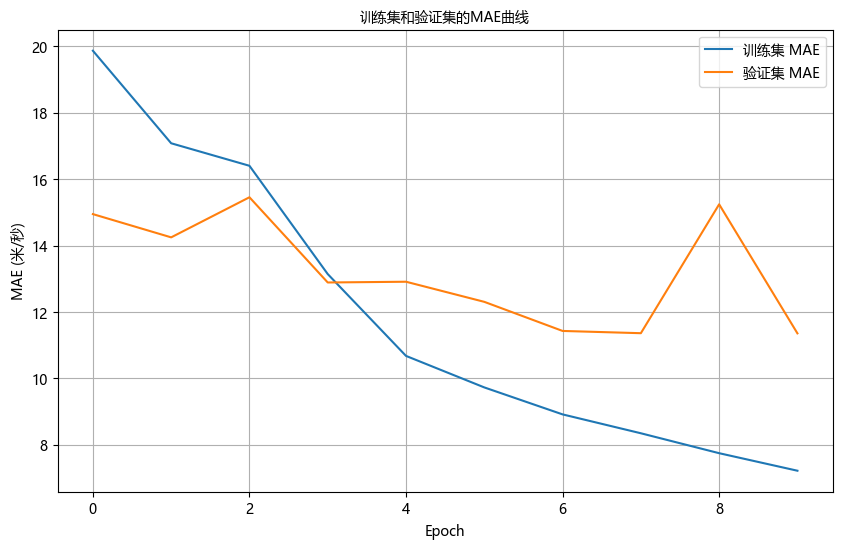

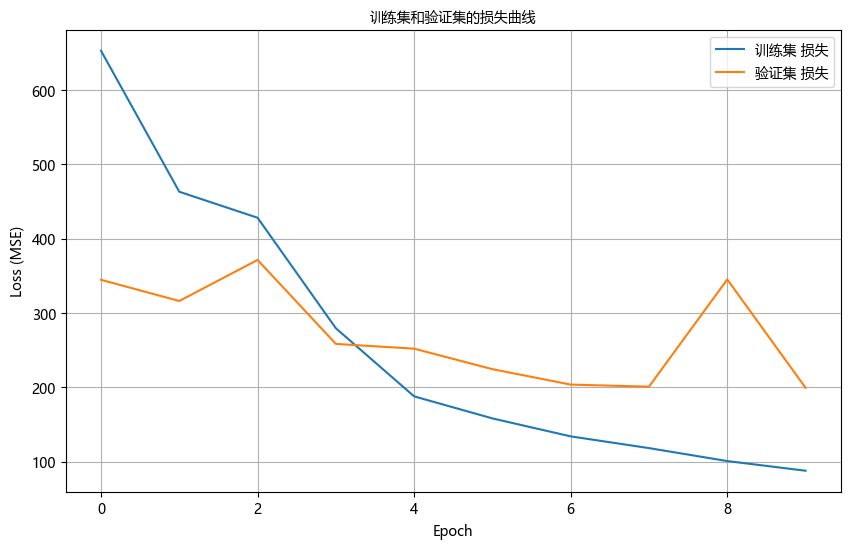

In [8]:
# 绘制训练集和验证集的MAE曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='训练集 MAE')
plt.plot(history.history['val_mae'], label='验证集 MAE')
plt.xlabel('Epoch', fontproperties=my_font)
plt.ylabel('MAE (米/秒)', fontproperties=my_font)
plt.legend(prop=my_font)
plt.title('训练集和验证集的MAE曲线', fontproperties=my_font)
plt.grid(True)
plt.show()

# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='训练集 损失')
plt.plot(history.history['val_loss'], label='验证集 损失')
plt.xlabel('Epoch', fontproperties=my_font)
plt.ylabel('Loss (MSE)', fontproperties=my_font)
plt.legend(prop=my_font)
plt.title('训练集和验证集的损失曲线', fontproperties=my_font)
plt.grid(True)
plt.show()

8. 加载测试集数据

In [9]:
train_data_dir = 'train_data'
val_data_dir = 'val_data'
test_data_dir = 'tst'

X_train, _, y_train = load_data(train_data_dir, has_subdirs=True)
X_val, _, y_val = load_data(val_data_dir, has_subdirs=True)
X_test, _, y_test = load_data(test_data_dir, has_subdirs=False)

# 增加通道维度（例如：从 (N, H, W) 到 (N, H, W, 1)）
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"训练集大小: {X_train.shape}")
print(f"验证集大小: {X_val.shape}")
print(f"测试集大小: {X_test.shape}")



训练集大小: (8214, 64, 64, 1)
验证集大小: (1313, 64, 64, 1)
测试集大小: (242, 64, 64, 1)


9. 使用测试集评估模型性能

In [10]:
# 评估模型在测试集上的性能
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"测试集损失: {test_loss}")
print(f"测试集平均绝对误差: {test_mae}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 158.8031 - mae: 10.1144
测试集损失: 183.71778869628906
测试集平均绝对误差: 10.908145904541016


10.使用测试集进行预测并可视化结果

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
测试样本 1 的预测风速: 34.70602035522461 m/s
测试样本 2 的预测风速: 32.53730773925781 m/s
测试样本 3 的预测风速: 37.645565032958984 m/s


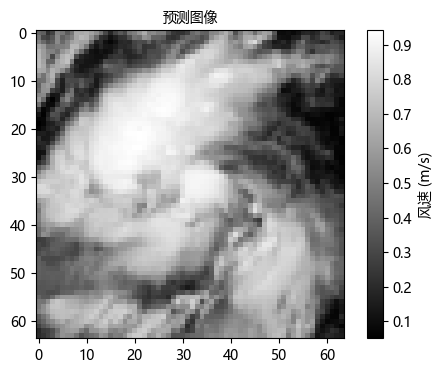

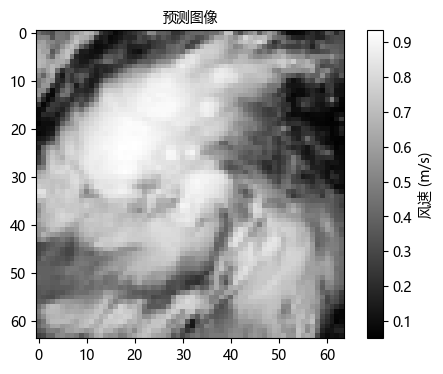

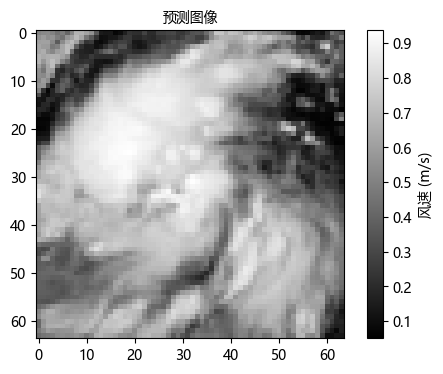

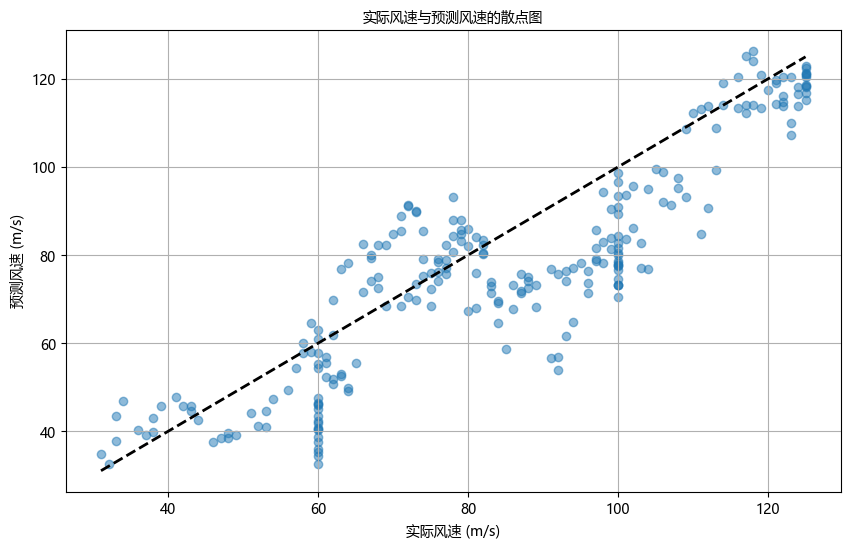

In [12]:
import matplotlib.pyplot as plt

# 使用测试集数据进行预测
test_predictions = model.predict(X_test)

# 输出预测风速到控制台
for i in range(3):
    print(f"测试样本 {i+1} 的预测风速: {test_predictions[i][0]} m/s")

# 可视化测试集预测结果
for i in range(3):
    plt.figure(figsize=(6, 4))
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title("预测图像", fontproperties=my_font)
    plt.colorbar(label='风速 (m/s)')
    plt.show()

# 绘制预测值与实际值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('实际风速 (m/s)', fontproperties=my_font)
plt.ylabel('预测风速 (m/s)', fontproperties=my_font)
plt.title('实际风速与预测风速的散点图', fontproperties=my_font)
plt.grid(True)
plt.show()


